<a href="https://colab.research.google.com/github/Harm1995/CTA-sensitivity/blob/master/Count_maps.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Packages

In [0]:
try:
  import gammapy
  import iminuit
  from iminuit import Minuit

except:

  !pip install gammapy
  !pip install iminuit

In [0]:
import matplotlib.pyplot as plt
import matplotlib as mpl
import numpy as np
import math
from astropy.io import fits
from astropy import units as u
import gammapy
from gammapy.irf import Background3D
import pandas as pd 
import random
import scipy
from scipy.stats import norm
import seaborn as sns
import time
from tqdm.auto import tqdm, trange

sns.set()


In [0]:
roi = 5
TeV = 10**-6
energy_start_bin = 3
offset = 0
pre_normalisation = 1
time_obs = 500 * 3600
pixel_size = (np.pi / 180)**2 * 0.5**2

# Data

## Diffusive data

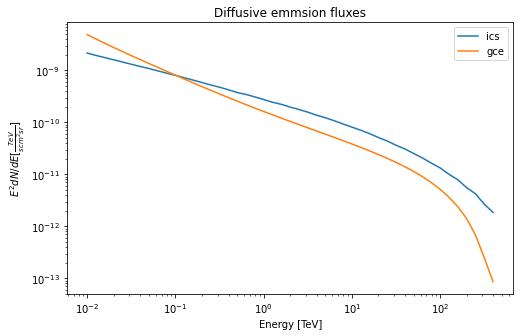

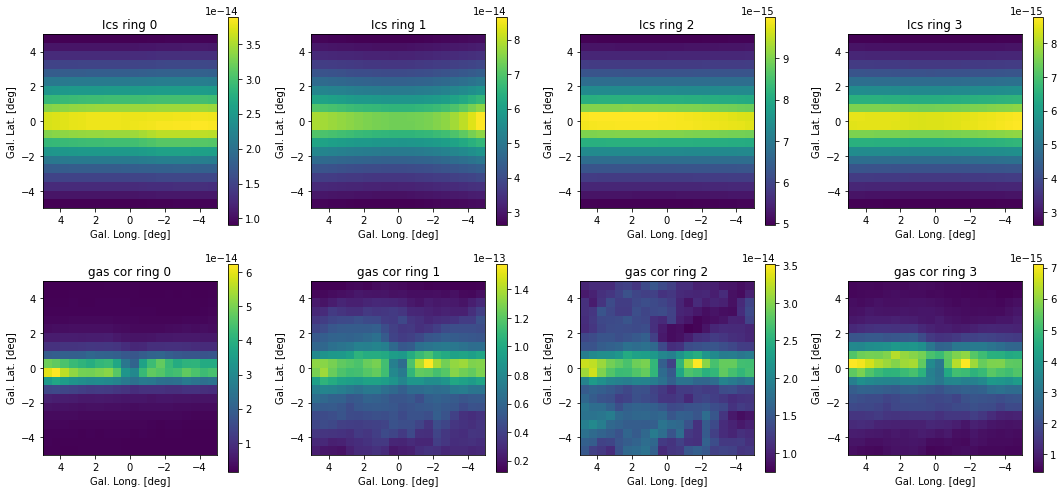

In [0]:
pre_path = "/content/drive/My Drive/Colab Notebooks/master_project/"
ring_path = "/content/drive/My Drive/Colab Notebooks/master_project/rings_background/"


### Here we get the diffusive emission maps:
ics_ring_maps = []
GCE_ring_maps = []
for i in range(1,5):
  ics = np.roll(fits.getdata(ring_path + 'ics_ring_'+str(i) +'_new2.fits', ext=0), 360, axis=2)[:, (180 - roi * 2):(180 + roi * 2), (360 - roi * 2):(360 + roi * 2)]
  brems = np.roll(fits.getdata(ring_path + 'bremss_ring_'+ str(i) +'_new2.fits', ext=0), 360, axis=2)[:, (180 - roi * 2):(180 + roi * 2), (360 - roi * 2):(360 + roi * 2)]
  pion = np.roll(fits.getdata(ring_path + 'pion_decay_ring_'+ str(i) +'_new2.fits', ext=0), 360, axis=2)[:, (180 - roi * 2):(180 + roi * 2), (360 - roi * 2):(360 + roi * 2)]
  ics_ring_maps.append(ics)
  GCE_ring_maps.append(brems + pion)


tot_ics = np.array(ics_ring_maps[0] + ics_ring_maps[1] + ics_ring_maps[2] + ics_ring_maps[3])
tot_gce = np.array(GCE_ring_maps[0] + GCE_ring_maps[1] + GCE_ring_maps[2] + GCE_ring_maps[3])

GDE_maps = []
GDE_maps.append(ics_ring_maps)
GDE_maps.append(GCE_ring_maps)
GDE_maps = np.array(GDE_maps)

fermi_map = fits.getdata(pre_path + 'fig12_bubbles_template_3compSCA_40x40deg_inpaint.fits')[(40 - 2*roi):(40 + 2 * roi),(40 - 2*roi):(40 + 2 * roi)]
fermi_map = fermi_map / np.mean(fermi_map)


ics_ring_maps = np.array(ics_ring_maps)
GCE_ring_maps = np.array(GCE_ring_maps)


# The energy list is some sort of tuple, via this way I make it a normal array of energies:
energy_list1 = np.array(fits.getdata(ring_path + 'ics_ring_1.fits', ext=1))
energies = []
for energy in energy_list1:
    E = float(str(energy)[1:-2])
    energies.append(E)
energies = np.array(energies)
energies = energies * TeV   

ics_flux = [10**6*E*E*np.mean(tot_ics[i]) for i,E in enumerate(energies)]
gce_flux = [10**6*E*E*np.mean(tot_gce[i]) for i,E in enumerate(energies)]



fig,ax = plt.subplots(figsize = (8,5))

ax.plot(energies, ics_flux, label = 'ics')
ax.plot(energies, gce_flux, label = 'gce')
ax.set_ylabel(r'$E^{2}dN/dE [\frac{TeV}{s cm^{2} sr}]$')
ax.set_xlabel(r'Energy [TeV]')
ax.set(title = 'Diffusive emmsion fluxes', xscale = 'log', yscale = 'log')
ax.legend()
plt.show()

fig,ax = plt.subplots(2,4, figsize= (15,7))
shrink = 1
for i in range(4):
  plot = ax[0][i].imshow(ics_ring_maps[i][energy_bin], extent = [roi,-roi,-roi,roi])
  ax[0][i].set(xlabel = "Gal. Long. [deg]", ylabel = "Gal. Lat. [deg]", title = f'Ics ring {i}')
  fig.colorbar(plot, ax = ax[0][i], shrink = shrink)

for i in range(4):
  plot = ax[1][i].imshow(GCE_ring_maps[i][energy_bin], extent = [roi,-roi,-roi,roi])
  ax[1][i].set(xlabel = "Gal. Long. [deg]", ylabel = "Gal. Lat. [deg]",  title = f'gas cor ring {i}')
  fig.colorbar(plot, ax = ax[1][i], shrink = shrink)

fig.tight_layout()
plt.show()

## Fermi renormalisation

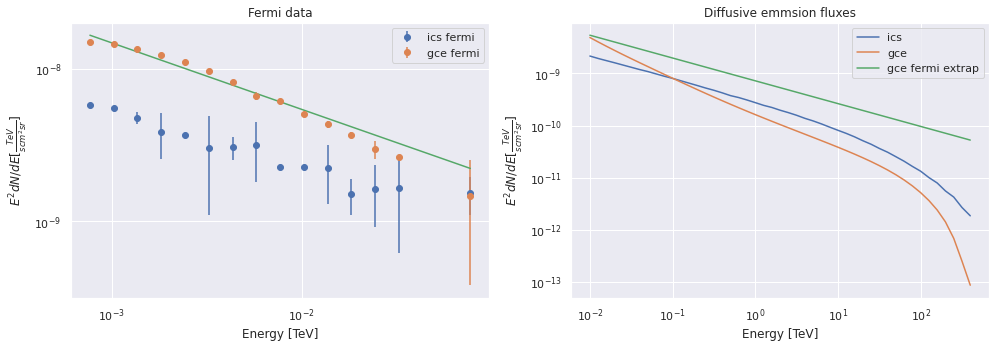

In [0]:
path = "/content/drive/My Drive/Colab Notebooks/data_txt_files/"

df_ics = pd.read_table(path+ 'ICS_spectra_40x40_roi_Abazajian_etal_2020.dat', skiprows=1, sep = ' '
  , header = None,  names= ['Emin', 'Emax','Ecenter',  'E^2dN/dE', 'error'])

df_gce = pd.read_table(path+ 'GasCorrelated_spectra_40x40_roi_Abazajian_etal_2020.dat', skiprows=1, sep = ' '
  , header = None,  names= ['Emin', 'Emax','Ecenter',  'E^2dN/dE', 'error'])

Fermi_eneriges_ics = df_ics['Ecenter'] /1000
Fermi_flux_ics = df_ics['E^2dN/dE']/1000
error1 = df_ics['error']/1000

Fermi_eneriges_gce = df_gce['Ecenter']/1000
Fermi_flux_gce = df_gce['E^2dN/dE']/1000
error2 = df_gce['error']/1000

def func(E, *param):
  return (param[0] * E**-param[1])

param,errors = scipy.optimize.curve_fit(func,Fermi_eneriges_gce, Fermi_flux_gce,p0 = [[10**-8,2]])
fit_func1 = [func(E,*param) for E in Fermi_eneriges_gce]
fit_func2 = [func(E,*param) for E in energies]

energy_bin = 10
GCE_ring_1_temp = GCE_ring_maps[0][energy_bin] / np.mean(tot_gce[energy_bin]) 
GCE_ring_2_temp = GCE_ring_maps[1][energy_bin] / np.mean(tot_gce[energy_bin]) 
GCE_ring_3_temp = GCE_ring_maps[2][energy_bin] / np.mean(tot_gce[energy_bin]) 
GCE_ring_4_temp = GCE_ring_maps[3][energy_bin] / np.mean(tot_gce[energy_bin]) 

new_GCE_1 = []
new_GCE_2 = []
new_GCE_3 = []
new_GCE_4 = []

param2 = [param[0], param[1] +2]
for E in energies:
  new_GCE_1.append(GCE_ring_1_temp * func(E, *param2))
  new_GCE_2.append(GCE_ring_2_temp * func(E, *param2))
  new_GCE_3.append(GCE_ring_3_temp * func(E, *param2))
  new_GCE_4.append(GCE_ring_4_temp * func(E, *param2))

new_GCE_1 = np.array(new_GCE_1)*10**-6
new_GCE_2 = np.array(new_GCE_2)*10**-6
new_GCE_3 = np.array(new_GCE_3)*10**-6
new_GCE_4 = np.array(new_GCE_4)*10**-6

fermi_extra = []
for i in range(47):
  fermi_extra.append((np.mean(new_GCE_1[i]) + np.mean(new_GCE_2[i]) + np.mean(new_GCE_3[i]) + np.mean(new_GCE_4[i]) )*energies[i]**2 * 10**6)



fig,(ax1,ax) = plt.subplots(1,2,figsize = (14,5))

ax.plot(energies, ics_flux, label = 'ics')
ax.plot(energies, gce_flux, label = 'gce')
ax.plot(energies, fermi_extra, label = 'gce fermi extrap')
ax.set_ylabel(r'$E^{2}dN/dE [\frac{TeV}{s cm^{2} sr}]$')
ax.set_xlabel(r'Energy [TeV]')
ax.set(title = 'Diffusive emmsion fluxes', xscale = 'log', yscale = 'log')
ax.legend()


ax1.errorbar(Fermi_eneriges_ics, Fermi_flux_ics, yerr= error1, fmt='o', label = 'ics fermi')
ax1.errorbar(Fermi_eneriges_gce, Fermi_flux_gce,yerr= error2, fmt='o', label = 'gce fermi')
ax1.plot(Fermi_eneriges_gce, fit_func1)
ax1.set(yscale = 'log', xscale= 'log', ylabel = r'$E^{2}dN/dE [\frac{TeV}{s cm^{2} sr}]$', xlabel = r'Energy [TeV]', title = 'Fermi data')
ax1.legend()


fig.tight_layout()

plt.show()

## The signal

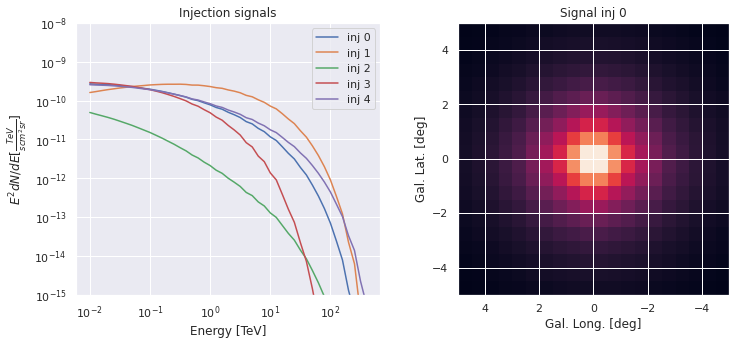

In [0]:
path_to_signal = '/content/drive/My Drive/Colab Notebooks/data_txt_files/NB_and_F98/'
NB_ring_maps = []
F98_ring_maps = []
injections = ['inj0','inj1', 'inj2', 'inj3', 'inj4']
for inj in injections:
  temp_map = []
  temp_map2 = []
  for ring in range(1,5):
    NB_map = np.roll(fits.getdata(path_to_signal + 'NB_ring_'+ str(ring) +'_' + inj + '.fits', ext=0), 360, axis=2)[:, (180 - roi * 2):(180 + roi * 2), (360 - roi * 2):(360 + roi * 2)]
    F98_map = np.roll(fits.getdata(path_to_signal + 'NB_ring_'+ str(ring) +'_' + inj +  '.fits', ext=0), 360, axis=2)[:, (180 - roi * 2):(180 + roi * 2), (360 - roi * 2):(360 + roi * 2)]
    temp_map.append(NB_map)
    temp_map2.append(F98_map)
  tot1 = temp_map[0] + temp_map[1] + temp_map[2] + temp_map[3]
  tot2 = temp_map2[0] + temp_map2[1] + temp_map2[2] + temp_map2[3]
  NB_ring_maps.append(tot1)
  F98_ring_maps.append(tot2)

NB_ring_maps = np.array(NB_ring_maps)
F98_ring_maps = np.array(F98_ring_maps)

l1 = [np.mean(NB_ring_maps[0][i] * energies[i]**2 * 10**6) for i in range(47)]
l2 = [np.mean(NB_ring_maps[1][i] * energies[i]**2 * 10**6) for i in range(47)]
l3 = [np.mean(NB_ring_maps[2][i] * energies[i]**2 * 10**6) for i in range(47)]
l4 = [np.mean(NB_ring_maps[3][i] * energies[i]**2 * 10**6) for i in range(47)]
l5 = [np.mean(NB_ring_maps[4][i] * energies[i]**2 * 10**6) for i in range(47)]

fig,(ax, ax1) = plt.subplots(1,2, figsize = (12,5))
ax.plot(energies, l1, label = "inj 0")
ax.plot(energies, l2, label = "inj 1")
ax.plot(energies, l3, label = "inj 2")
ax.plot(energies, l4, label = "inj 3")
ax.plot(energies, l5, label = "inj 4")
ax.set(yscale = 'log', xscale= 'log', ylabel = r'$E^{2}dN/dE [\frac{TeV}{s cm^{2} sr}]$', xlabel = r'Energy [TeV]', title = 'Injection signals')
ax.set_ylim(10**-15,10**-8)
ax.legend()


plot = ax1.imshow(NB_ring_maps[0][10], extent = [roi,-roi,-roi,roi])
ax1.set(xlabel = "Gal. Long. [deg]", ylabel = "Gal. Lat. [deg]",  title = f'Signal inj 0')
plt.show()

## The IRF data

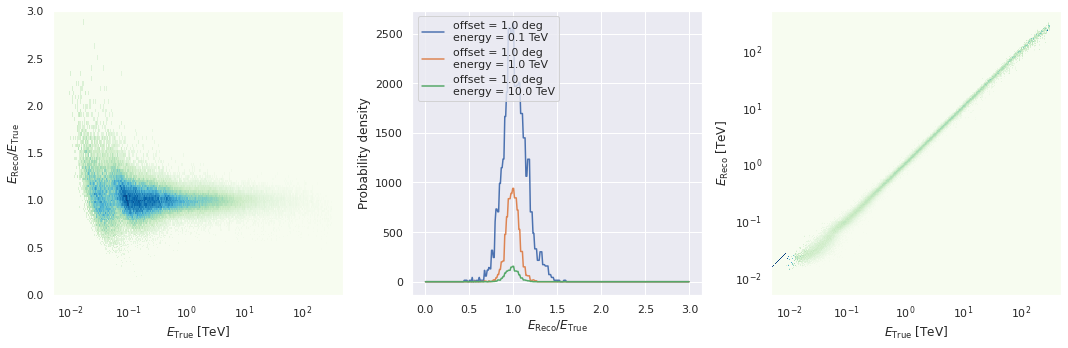

In [0]:
### And the irstrument respons function data:

irf_filename = pre_path + 'irf_file.fits'
aeff = gammapy.irf.EffectiveAreaTable2D.read(irf_filename, hdu="EFFECTIVE AREA")
edisp = gammapy.irf.EnergyDispersion2D.read(irf_filename, hdu="ENERGY DISPERSION")
psf = gammapy.irf.EnergyDependentMultiGaussPSF.read(irf_filename, hdu="POINT SPREAD FUNCTION")
bkg = Background3D.read(irf_filename, hdu='BACKGROUND')

def Eff_area(E_true):
   return (np.array(aeff.data.evaluate(energy_true=str(E_true) + " TeV", offset=str(1) + "deg").to("cm2")))

def Energy_disp(E_true, migrad):
   return edisp.data.evaluate(energy_true = str(E_true) + "TeV", offset=str(1) + "deg", migra = str(migrad))[0]

edisp.peek()



## The Fermi bubbles

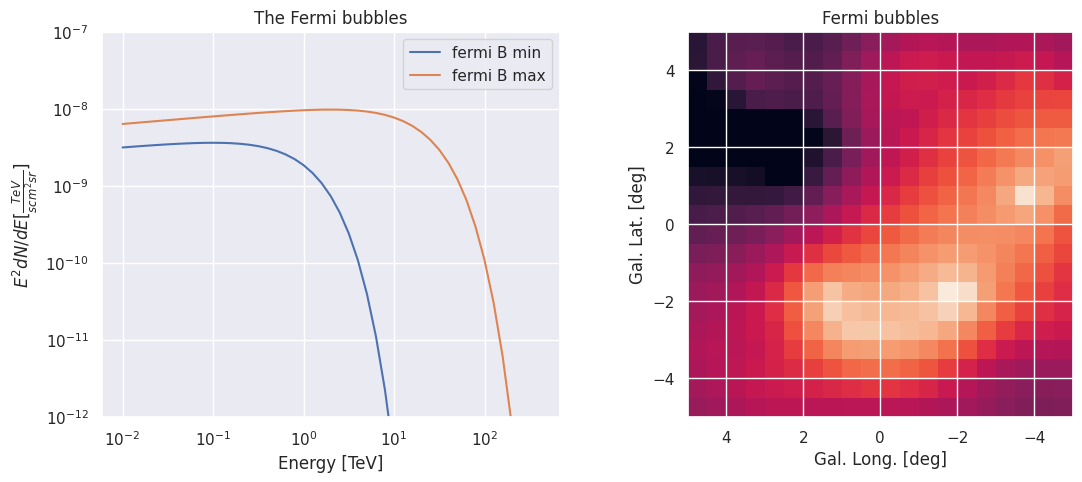

In [0]:
def fermi_function_min(E):
  phi0 = 0.5 * 10**-8
  sigma = 1.9
  E_co = 1

  fluxq = phi0 * np.exp(-E/E_co) * E**-sigma
  return fluxq

def fermi_function_max(E):
  phi0 = 1 * 10**-8
  sigma = 1.9
  E_co = 20

  fluxq = phi0 * np.exp(-E/E_co) * E**-sigma
  return fluxq

fermi_map = fits.getdata(pre_path + 'fig12_bubbles_template_3compSCA_40x40deg_inpaint.fits')[(40 - 2*roi):(40 + 2 * roi),(40 - 2*roi):(40 + 2 * roi)]
fermi_map = fermi_map / np.mean(fermi_map)


fermi_binned_min = []
fermi_binned_max = []

for E in energies:
  fermi_binned_min.append(fermi_map * fermi_function_min(E))
  fermi_binned_max.append(fermi_map * fermi_function_max(E))


fermi_binned_min = np.array(fermi_binned_min) * 10**-6
fermi_binned_max = np.array(fermi_binned_max) * 10**-6

fermi_min_flux = [np.mean(fermi_binned_min[i]) * energies[i]**2 * 10**6 for i in range(47)]
fermi_max_flux = [np.mean(fermi_binned_max[i]) * energies[i]**2 * 10**6 for i in range(47)]

sns.set()

fig,(ax, ax1) = plt.subplots(1,2,figsize = (13,5))
ax.plot(energies, fermi_min_flux, label = "fermi B min")
ax.plot(energies, fermi_max_flux, label = "fermi B max")
ax.set(yscale = 'log', xscale= 'log', ylabel = r'$E^{2}dN/dE [\frac{TeV}{s cm^{2} sr}]$', xlabel = r'Energy [TeV]', title = 'The Fermi bubbles')
ax.set_ylim(10**-12,10**-7)
ax.legend()

ax1.imshow(fermi_map, extent = [roi,-roi,-roi,roi])
ax1.set(xlabel = "Gal. Long. [deg]", ylabel = "Gal. Lat. [deg]",  title = f'Fermi bubbles')

plt.show()




## Alternative data

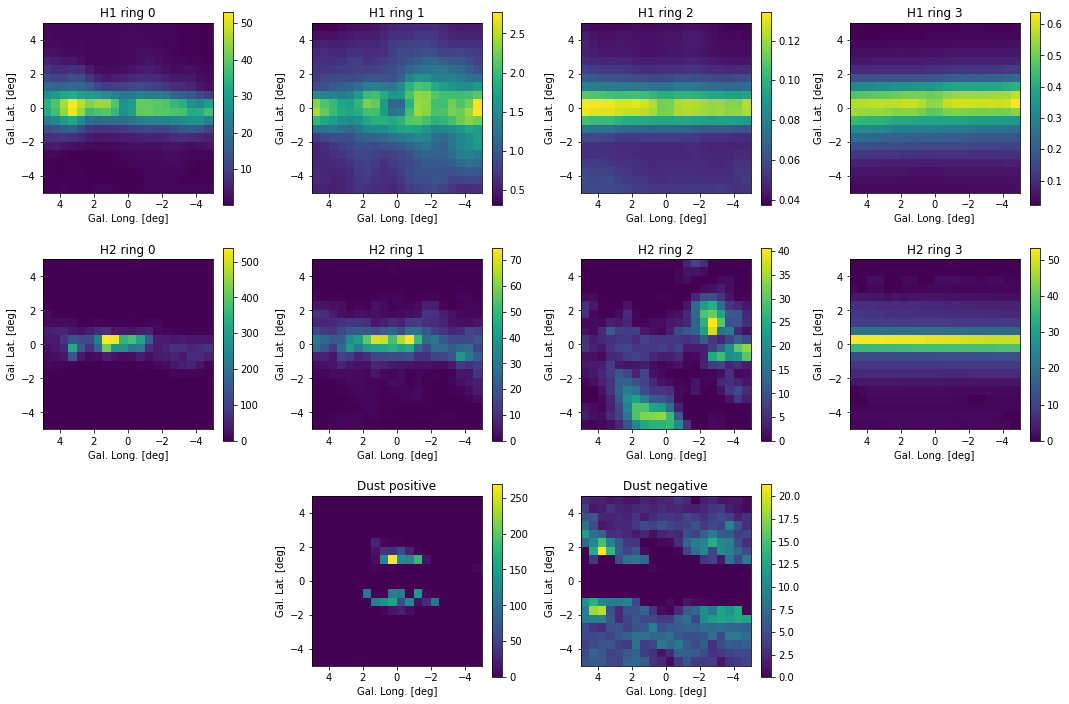

In [0]:
pre_path_alt = '/content/drive/My Drive/Colab Notebooks/master_project/Alternative_GDE/'

sns.reset_orig()

dust_pos =fits.getdata(pre_path_alt + 'DustPositive_Normalized.fits')[(40 - roi * 2):(40 + roi * 2), (40 - roi * 2):(40 + roi * 2)]
dust_neg =fits.getdata(pre_path_alt + 'DustNegative_Normalized.fits')[(40 - roi * 2):(40 + roi * 2), (40 - roi * 2):(40 + roi * 2)]

dust_neg = np.array(dust_neg)
dust_pos = np.array(dust_pos)

H1_maps = []
H2_maps = []
for ring in range(1,5):
  map_H2 = fits.getdata(pre_path_alt + f'H2_pohl_ring_{ring}_Normalized.fits')[(40 - roi * 2):(40 + roi * 2), (40 - roi * 2):(40 + roi * 2)]
  map_H1 = fits.getdata(pre_path_alt + f'HI_pohl_T150K_ring_{ring}_Normalized.fits')[(180 - roi * 2):(180 + roi * 2), (360 - roi * 2):(360 + roi * 2)]
  H1_maps.append(map_H1)
  H2_maps.append(map_H2)

H1_maps = np.array(H1_maps)
H2_maps = np.array(H2_maps)

fig, ax = plt.subplots(3,4, figsize = (15,10))

for i in range(4):
  a = ax[0][i].imshow(H1_maps[i], extent = [roi,-roi,-roi,roi])
  ax[0][i].set(xlabel = "Gal. Long. [deg]", ylabel = "Gal. Lat. [deg]",  title = f'H1 ring {i}')
  fig.colorbar(a, ax= ax[0][i])

for i in range(4):
  a = ax[1][i].imshow(H2_maps[i],extent = [roi,-roi,-roi,roi])
  ax[1][i].set(xlabel = "Gal. Long. [deg]", ylabel = "Gal. Lat. [deg]",  title = f'H2 ring {i}')
  fig.colorbar(a, ax= ax[1][i])

plot = ax[2][1].imshow(dust_neg, extent = [roi,-roi,-roi,roi])
ax[2][1].set(xlabel = "Gal. Long. [deg]", ylabel = "Gal. Lat. [deg]",  title = f'Dust positive')
fig.colorbar(plot, ax = ax[2][1], shrink = shrink)

plot = ax[2][2].imshow(dust_pos, extent = [roi,-roi,-roi,roi])
ax[2][2].set(xlabel = "Gal. Long. [deg]", ylabel = "Gal. Lat. [deg]",  title = f'Dust negative')
fig.colorbar(plot, ax = ax[2][2], shrink = shrink)

fig.delaxes(ax[2][0])
fig.delaxes(ax[2][3])


fig.tight_layout()


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:11: RuntimeWarning: invalid value encountered in power
  # This is added back by InteractiveShellApp.init_path()


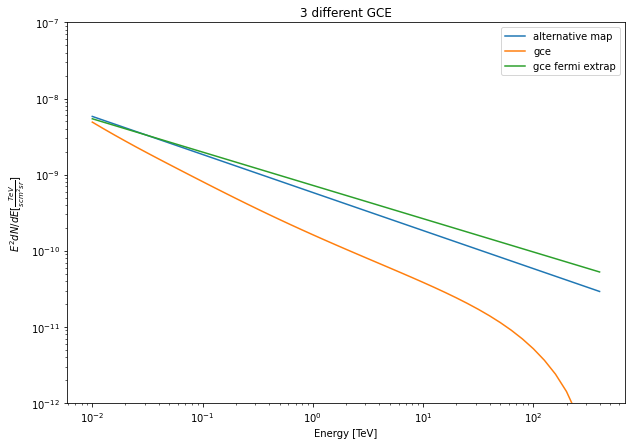

In [0]:
import scipy

tot_alter = np.sum(H1_maps) + np.sum(H1_maps) + np.sum(dust_pos)+ np.sum(dust_neg) 
sum_gce = np.sum(tot_gce)

l2 = []
for i in range(47):
  l2.append(np.sum(tot_gce[i]))

def func(E,a,b,c):
  return (a * (E/b)**-c)

p1,p2 = scipy.optimize.curve_fit(func,energies, l2)


norm_factor = sum_gce / tot_alter

def func(E):
  b = float(0.2)
  c = float(2.5)

  return ((E/b)**-c * norm_factor *10**-3.8)



H1_1_binned = []
H1_2_binned = []
H1_3_binned = []
H1_4_binned = []

H2_1_binned = []
H2_2_binned = []
H2_3_binned = []
H2_4_binned = []

dust_binned_pos = []
dust_binned_neg = []

for E in energies:
  H1_1_binned.append(H1_maps[0] * func(E))
  H1_2_binned.append(H1_maps[1] * func(E))
  H1_3_binned.append(H1_maps[2] * func(E))
  H1_4_binned.append(H1_maps[3] * func(E))

  H2_1_binned.append(H2_maps[0] * func(E))
  H2_2_binned.append(H2_maps[1] * func(E))
  H2_3_binned.append(H2_maps[2] * func(E))
  H2_4_binned.append(H2_maps[3] * func(E))

  dust_binned_pos.append(dust_pos * func(E))
  dust_binned_neg.append(dust_neg * func(E))

tot_alt = [H1_1_binned,H1_2_binned, H1_3_binned, H1_4_binned, H2_1_binned,H2_2_binned, H2_3_binned, H2_4_binned,dust_binned_pos,dust_binned_neg]
tot_alt = np.array(tot_alt)


H1_1_binned = np.array(H1_1_binned)
H1_2_binned = np.array(H1_2_binned)
H1_3_binned = np.array(H1_3_binned)
H1_4_binned = np.array(H1_4_binned)

H2_1_binned = np.array(H2_1_binned)
H2_2_binned = np.array(H2_2_binned)
H2_3_binned = np.array(H2_3_binned)
H2_4_binned = np.array(H2_4_binned)

dust_binned_pos = np.array(dust_binned_pos)
dust_binned_neg = np.array(dust_binned_neg)

sum_alt = np.sum(tot_alt, axis = 0)

l = [np.mean(sum_alt[i])*energies[i]**2 * 10**6 for i in range(47)]

fig,ax = plt.subplots(figsize = (10,7))
ax.plot(energies, l, label = "alternative map")
ax.plot(energies, gce_flux, label = 'gce')
ax.plot(energies, fermi_extra, label = 'gce fermi extrap')
ax.set(yscale = 'log', xscale= 'log', ylabel = r'$E^{2}dN/dE [\frac{TeV}{s cm^{2} sr}]$', xlabel = r'Energy [TeV]', title = '3 different GCE')
ax.set_ylim(10**-12,10**-7)
ax.legend()
plt.show()




# Mask matrix

In [0]:
def mask_matrix_fu():

  catalog = fits.open(pre_path + 'gll_psch_v13.fit')

  ptsrc_long = []
  ptsrc_lat = []

  # Here is load all the point sources in our range of interest:
  for i in range(len(catalog[1].data)):
      if(catalog[1].data[i][9] > 4.0 and catalog[1].data[i][33] == ''):
          if(-roi + 180 <= catalog[1].data[i][3] <= roi + 180):
              if(-roi <= catalog[1].data[i][4] <= roi):
                  ptsrc_long.append(catalog[1].data[i][3])
                  ptsrc_lat.append(catalog[1].data[i][4])

  # Here I make a matrix that has a zero on all the positions that are +/- 0.25 degrees away from
  # a Fermi high energy source. Also the galactic ridge (+/- 0.3 degrees lattitude) are maskt.
  mask_matrix = []
  y_coor = 0
  x_min = 180 - roi
  x_max = 180 + roi
  y_min = - roi
  y_max = roi
  y_steps = 4 * roi
  x_steps = 4 * roi

  for y in np.linspace(y_max, y_min, y_steps):
      mask_matrix.append([])
      for x in np.linspace(x_min, x_max, x_steps):
          mark = 1
          for i in range(len(ptsrc_long)):
              ps_x = ptsrc_long[i]
              ps_y = ptsrc_lat[i]
              if abs(ps_x - x) < 0.25:
                  if abs(ps_y - y) < 0.25:
                      mark = 0
                      break
  #            if ((ps_x - x)**2 + (ps_y - y)**2)**0.5  < 0.25:
  #                mark = 0
          if abs(y) < 0.3:
              mark = 0
          mask_matrix[y_coor].append(mark)
      y_coor += 1

  mask_matrix = np.array(mask_matrix)
  return mask_matrix

mask_matrix = mask_matrix_fu()


# Analysis

In [0]:
def norm_factor(bin):
  tot = 0
  E = energies[bin]
  for i in range(47):
    migrad = E / energies[i]
    di = Energy_disp(E, migrad) 

    tot += di

  return tot

norm_factors = []
for i in range(47):
  fa = norm_factor(i)
  if fa ==0:
    fa = 1
  norm_factors.append(fa)

Eff_area_l = []
for k in range(47):
  E_reco = energies[k]
  Area = Eff_area(E_reco)
  Eff_area_l.append(Area)



In [0]:

def convolved_map(map_count):
  a= np.zeros(shape = map_count.shape)
  for i in tqdm(range(20)):
    for j in range(20):
      
      for bin in range(47):
        norm = norm_factors[bin]
        E_true = energies[bin]
        

        for k in range(47):
          E_reco = energies[k]
          migrad = E_true / E_reco
          di = Energy_disp(E_true, migrad) / norm
          Area = Eff_area_l[k]
          a[k][i][j] += map_count[k][i][j] * di * Area
  
  return a

def total_counts(map_count):
  map_c = convolved_map(map_count)
  convolved = np.zeros(shape= (46,20,20))
  for i,j,k in np.ndindex(46,20,20):
    E1 = energies[i]
    E2 = energies[i+1]
    dE = E2 -E1
    convolved[i][j][k] = map_c[i][j][k] * dE * 10**6

  return convolved





# For every map

### ICS

In [0]:
files_paths = '/content/drive/My Drive/Colab Notebooks/data_txt_files/'
ics_file = open(files_paths + 'ice_file.txt', "w")
print ('file 1:')
ics_ring_1_conv = total_counts(ics_ring_maps[0])
print ('file 2:')
ics_ring_2_conv = total_counts(ics_ring_maps[1])
print ('file 3:')
ics_ring_3_conv = total_counts(ics_ring_maps[2])
print ('file 4:')
ics_ring_4_conv = total_counts(ics_ring_maps[3])

ics_conv = [ics_ring_1_conv, ics_ring_2_conv, ics_ring_3_conv, ics_ring_4_conv]
ics_conv = np.array(ics_conv) * mask_matrix * time * pixel_size

for i in np.ndindex(ics_conv.shape):
  np.savetxt(ics_file, [ics_conv[i]])

ics_file.close()


file 1:

at 0.0 %

at 5.263157894736842 %

at 10.526315789473683 %

at 15.789473684210526 %

at 21.052631578947366 %

at 26.31578947368421 %

at 31.57894736842105 %

at 36.84210526315789 %

at 42.10526315789473 %

at 47.368421052631575 %

at 52.63157894736842 %

at 57.89473684210527 %

at 63.1578947368421 %

at 68.42105263157895 %

at 73.68421052631578 %

at 78.94736842105263 %

at 84.21052631578947 %

at 89.47368421052632 %



### Gas correlated 1

In [0]:
files_paths = '/content/drive/My Drive/Colab Notebooks/data_txt_files/'
gce_file = open(files_paths + 'gce_file.txt', "w")

print ('file 1:')
gce_ring_1_conv = total_counts(GCE_ring_maps[0])
print ('file 2:')
gce_ring_2_conv = total_counts(GCE_ring_maps[1])
print ('file 3:')
gce_ring_3_conv = total_counts(GCE_ring_maps[2])
print ('file 4:')
gce_ring_4_conv = total_counts(GCE_ring_maps[3])

gce_conv = [gce_ring_1_conv, gce_ring_2_conv, gce_ring_3_conv, gce_ring_4_conv]
gce_conv = np.array(gce_conv) * mask_matrix * time_obs * pixel_size

for i in np.ndindex(gce_conv.shape):
  np.savetxt(gce_file, [gce_conv[i]])

gce_file.close()


### Gas correlated 2


In [0]:
files_paths = '/content/drive/My Drive/Colab Notebooks/data_txt_files/'
gce2_file = open(files_paths + 'gce2_file.txt', "w")

print ('file 1:')
gce2_ring_1_conv = total_counts(new_GCE_1)
print ('file 2:')
gce2_ring_2_conv = total_counts(new_GCE_2)
print ('file 3:')
gce2_ring_3_conv = total_counts(new_GCE_3)
print ('file 4:')
gce2_ring_4_conv = total_counts(new_GCE_4)

gce2_conv = [gce2_ring_1_conv, gce2_ring_2_conv, gce2_ring_3_conv, gce2_ring_4_conv]
gce2_conv = np.array(gce2_conv) * mask_matrix * time_obs * pixel_size

for i in np.ndindex(gce2_conv.shape):
  np.savetxt(gce2_file, [gce2_conv[i]])

gce2_file.close()



file 1:



file 2:



file 3:



file 4:


### Gas correlated 3

In [0]:
files_paths = '/content/drive/My Drive/Colab Notebooks/data_txt_files/'
Alternative_gce_file = open(files_paths + 'Alternative_gce.txt', "w") 

print ('file 1:')
H1_1_conv = total_counts(H1_1_binned)
print ('file 2:')
H1_2_conv = total_counts(H1_2_binned)
print ('file 3:')
H1_3_conv = total_counts(H1_3_binned)
print ('file 4:')
H1_4_conv = total_counts(H1_4_binned)
print ('file 5:')
H2_1_conv = total_counts(H2_1_binned)
print ('file 6:')
H2_2_conv = total_counts(H2_2_binned)
print ('file 7:')
H2_3_conv = total_counts(H2_3_binned)
print ('file 8:')
H2_4_conv = total_counts(H2_4_binned)
print ('file 9:')
dust_pos_conv = total_counts(dust_binned_pos)
print ('file 10:')
dust_neg_conv = total_counts(dust_binned_neg)


alt_conv = [H1_1_conv,H1_2_conv,H1_3_conv,H1_4_conv,H2_1_conv,H2_2_conv,H2_3_conv,H2_4_conv, dust_pos_conv,dust_neg_conv]
alt_conv = np.array(alt_conv) * mask_matrix * time_obs * pixel_size

for i in np.ndindex(alt_conv.shape):
  np.savetxt(Alternative_gce_file, [alt_conv[i]])

Alternative_gce_file.close()

### NB Signal

In [0]:
files_paths = '/content/drive/My Drive/Colab Notebooks/data_txt_files/'
NB_file = open(files_paths + 'NB_file.txt', "w") 

print ('file 1:')
NB_1_conv = total_counts(NB_ring_maps[0])
print ('file 2:')
NB_2_conv = total_counts(NB_ring_maps[1])
print ('file 3:')
NB_3_conv = total_counts(NB_ring_maps[2])
print ('file 4:')
NB_4_conv = total_counts(NB_ring_maps[3])
print ('file 5:')
NB_5_conv = total_counts(NB_ring_maps[4])

NB_conv = [NB_1_conv, NB_2_conv, NB_3_conv, NB_4_conv, NB_5_conv]
NB_conv = np.array(NB_conv) * mask_matrix * time_obs * pixel_size

for i in np.ndindex(NB_conv.shape):
  np.savetxt(NB_file, [NB_conv[i]])

NB_file.close()


file 1:

at 0.0 %

at 5.263157894736842 %

at 10.526315789473683 %

at 15.789473684210526 %

at 21.052631578947366 %

at 26.31578947368421 %

at 31.57894736842105 %

at 36.84210526315789 %


### F98 Signal

In [0]:
files_paths = '/content/drive/My Drive/Colab Notebooks/data_txt_files/'
F98_file = open(files_paths + 'F98_file.txt', "w") 


print ('file 1:')
F98_1_conv = total_counts(F98_ring_maps[0])
print ('file 2:')
F98_2_conv = total_counts(F98_ring_maps[1])
print ('file 3:')
F98_3_conv = total_counts(F98_ring_maps[2])
print ('file 4:')
F98_4_conv = total_counts(F98_ring_maps[3])
print ('file 5:')
F98_5_conv = total_counts(F98_ring_maps[4])

F98_conv = [F98_1_conv, F98_2_conv, F98_3_conv, F98_4_conv,F98_5_conv]
F98_conv = np.array(F98_conv) * mask_matrix * time_obs * pixel_size

for i in np.ndindex(F98_conv.shape):
  np.savetxt(F98_file, [F98_conv[i]])

F98_file.close()

file 1:

at 0.0 %

at 5.263157894736842 %

at 10.526315789473683 %

at 15.789473684210526 %

at 21.052631578947366 %

at 26.31578947368421 %

at 31.57894736842105 %

at 36.84210526315789 %


### Fermi bubble

In [0]:
files_paths = '/content/drive/My Drive/Colab Notebooks/data_txt_files/'
fermi_file  = open(files_paths + 'fermi_map', "w") 

print ("The Femri min model:")
fermi_min = total_counts(fermi_binned_min)
print ("The Femri max model:")
fermi_max = total_counts(fermi_binned_max)

fermi_maps = np.array([fermi_min, fermi_max])* mask_matrix * time_obs * pixel_size


for i in np.ndindex(fermi_maps.shape):
  np.savetxt(fermi_file, [fermi_maps[i]])

fermi_file.close()



The Femri min model:



The Femri max model:


# Plotting the data

In [0]:
files_paths = '/content/drive/My Drive/Colab Notebooks/data_txt_files/'

ics_rings = np.loadtxt(files_paths + 'ice_file.txt').reshape(4,46,20,20)
gce_rings = np.loadtxt(files_paths + 'gce_file.txt').reshape(4,46,20,20)
gce2_rings = np.loadtxt(files_paths + 'gce2_file.txt').reshape(4,46,20,20)
NB_rings = np.loadtxt(files_paths + 'NB_file.txt').reshape(5,46,20,20)
F98_rings = np.loadtxt(files_paths + 'F98_file.txt').reshape(5,46,20,20)
alternative_gce = np.loadtxt(files_paths + 'Alternative_gce.txt').reshape(10,46,20,20)
fermi_maps = np.loadtxt(files_paths + 'fermi_map').reshape(2,46,20,20)

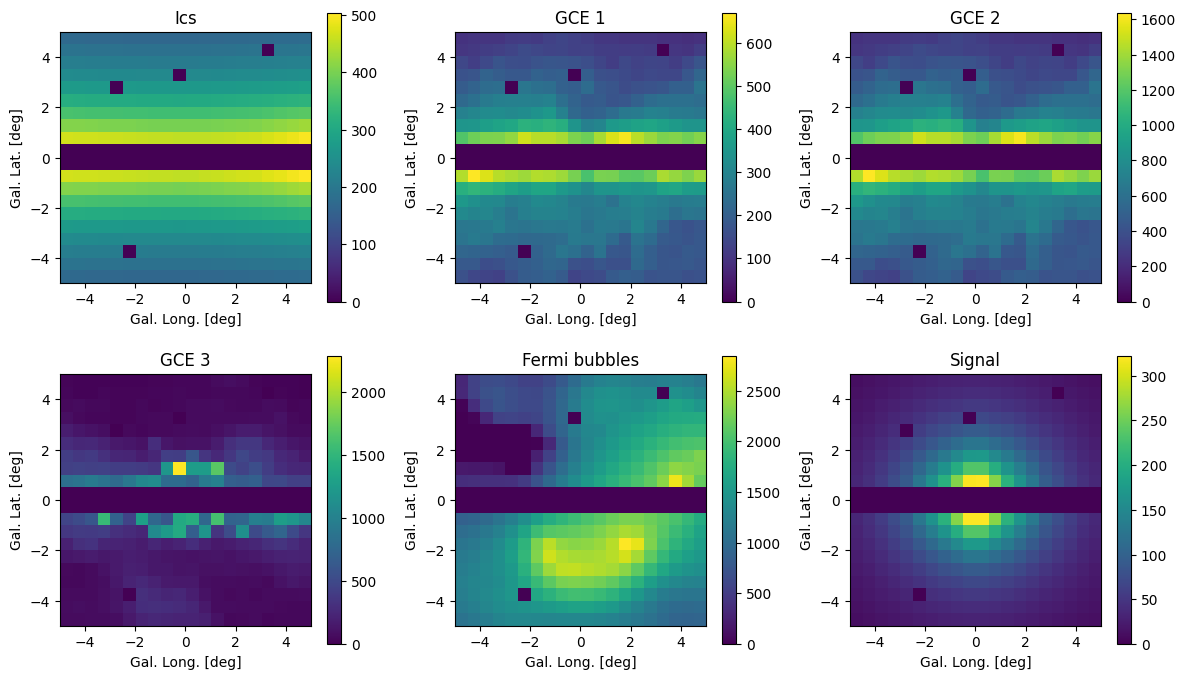

In [0]:
total_ics = np.sum(ics_rings, axis = 0)
total_gce1 = np.sum(gce_rings, axis = 0)
total_gce2 = np.sum(gce2_rings, axis = 0)
total_gce3 = np.sum(alternative_gce, axis = 0)

sns.reset_defaults()

fig,ax = plt.subplots(2,3, figsize = (12,7))
energy_bin = 10

p = ax[0][0].imshow(total_ics[energy_bin], extent = [-roi,roi,-roi,roi])
fig.colorbar(p,ax = ax[0][0])
ax[0][0].set(xlabel = "Gal. Long. [deg]", ylabel = "Gal. Lat. [deg]",  title = f'Ics')
p = ax[0][1].imshow(total_gce1[energy_bin], extent = [-roi,roi,-roi,roi])
fig.colorbar(p,ax = ax[0][1])
ax[0][1].set(xlabel = "Gal. Long. [deg]", ylabel = "Gal. Lat. [deg]",  title = f'GCE 1')
p = ax[0][2].imshow(total_gce2[energy_bin], extent = [-roi,roi,-roi,roi])
fig.colorbar(p,ax = ax[0][2])
ax[0][2].set(xlabel = "Gal. Long. [deg]", ylabel = "Gal. Lat. [deg]",  title = f'GCE 2')
p = ax[1][0].imshow(total_gce3[energy_bin], extent = [-roi,roi,-roi,roi])
fig.colorbar(p,ax = ax[1][0])
ax[1][0].set(xlabel = "Gal. Long. [deg]", ylabel = "Gal. Lat. [deg]",  title = f'GCE 3')
p = ax[1][1].imshow(fermi_maps[0][energy_bin], extent = [-roi,roi,-roi,roi])
fig.colorbar(p,ax = ax[1][1])
ax[1][1].set(xlabel = "Gal. Long. [deg]", ylabel = "Gal. Lat. [deg]",  title = f'Fermi bubbles')
p = ax[1][2].imshow(NB_rings[0][energy_bin], extent = [-roi,roi,-roi,roi])
fig.colorbar(p,ax = ax[1][2])
ax[1][2].set(xlabel = "Gal. Long. [deg]", ylabel = "Gal. Lat. [deg]",  title = f'Signal')


fig.tight_layout()

plt.show()

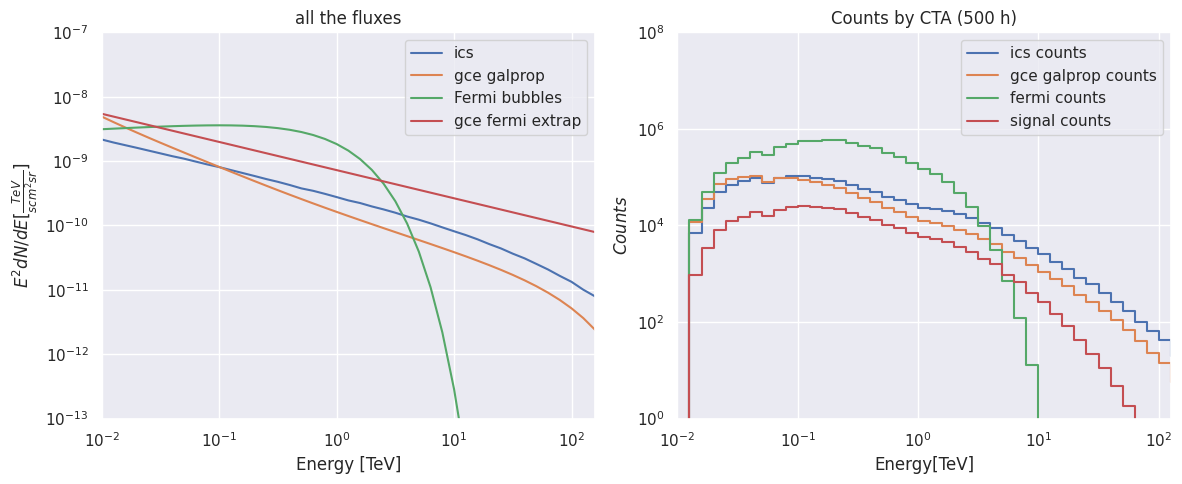

In [0]:
l1 = []
l2 = []
l3 = []
l4 = []
l5 = []
l6 = []


for i in range(46):
  l1.append(np.sum(total_ics[i]))
  l2.append(np.sum(total_gce1[i]))
  l3.append(np.sum(total_gce2[i]))
  l4.append(np.sum(total_gce3[i]))
  l5.append(np.sum(fermi_maps[0][i]))
  l6.append(np.sum(NB_rings[0][i]))

sns.set()

fig,ax = plt.subplots(1,2,figsize = (12,5))

ax[0].plot(energies, ics_flux, label = 'ics')
ax[0].plot(energies, gce_flux, label = 'gce galprop')
ax[0].plot(energies, fermi_min_flux, label = 'Fermi bubbles')
ax[0].plot(energies, fermi_extra, label = 'gce fermi extrap')
ax[0].set_ylabel(r'$E^{2}dN/dE [\frac{TeV}{s cm^{2} sr}]$')
ax[0].set_xlabel(r'Energy [TeV]')
ax[0].set_ylim(10**-13,10**-7)
ax[0].set_xlim(10**-2,10**2.2)
ax[0].set(title = 'all the fluxes', xscale = 'log', yscale = 'log')
ax[0].legend()


ax[1].step(energies[:-1], l1, label = 'ics counts')
ax[1].step(energies[:-1], l2, label = 'gce galprop counts')
#ax[1].step(energies[:-1], l3, label = 'gce fermi counts')
ax[1].step(energies[:-1], l5, label = 'fermi counts')
ax[1].step(energies[:-1], l6, label = 'signal counts')
ax[1].set_ylim(10**-0,10**8)
ax[1].set_xlim(10**-2,10**2.1)
ax[1].legend()
ax[1].set_ylabel(r'$Counts$')
ax[1].set_xlabel('Energy[TeV]')
ax[1].set(title = 'Counts by CTA (500 h)', xscale = 'log', yscale = 'log')

fig.tight_layout()
fig.show()